In [24]:
import kagglehub
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

path = kagglehub.dataset_download("abdallahwagih/retina-blood-vessel")

print("Path to dataset files:", path)

def load_retina_data(path, nb_img=None):
    
    def load_dir(path,dir_name, nb_img=None):
        path_dir = os.path.join(path, dir_name)
        images = []
        masks = []
        
        # List image and mask files and sort them for consistency
        img_files = sorted(os.listdir(os.path.join(path_dir, "image")))
        mask_files = sorted(os.listdir(os.path.join(path_dir, "mask")))
        
        for img_it, (img_file, mask_file) in enumerate(zip(img_files, mask_files)):
            img_path = os.path.join(path_dir, "image", img_file)
            mask_path = os.path.join(path_dir, "mask", mask_file)
            
            # Load and resize the image
            img = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L") 
            
            # Normalize pixel values to [0, 1]
            img = np.array(img) / 255.0
            mask = np.array(mask) / 255.0
            mask = np.rint(mask)
            # Append to lists
            images.append(img)
            masks.append(mask)
            if nb_img is not None and img_it>=nb_img-1:
                break
        
        return np.array(images), np.array(masks)
    x_train,y_train = load_dir(path,"train", nb_img=nb_img)
    x_test,y_test = load_dir(path,"test", nb_img=nb_img)
    return x_train,y_train,x_test,y_test


x_train_img,y_train_img,x_test_img,y_test_img = load_retina_data(os.path.join(path,"Data"), nb_img=80)
x = x_train_img
y = y_train_img

Path to dataset files: /home/antoine/.cache/kagglehub/datasets/abdallahwagih/retina-blood-vessel/versions/1


In [25]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import random

class RandomPatchDataset(Dataset):
    def __init__(self, images, masks, patch_size, transform=None):
        """
        Args:
            images: array
            patch_size: Tuple (k, k) specifying the size of the patch.
            transform: Transformations to apply to each patch (optional).
        """
        self.images = images
        self.masks = masks
        self.patch_size = patch_size
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        # Ensure the image is a tensor
        if not isinstance(image, torch.Tensor):
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)
        # Get the dimensions of the image
        _, h, w = image.shape

        # Extract a random patch
        top = random.randint(0, h - self.patch_size[0])
        left = random.randint(0, w - self.patch_size[1])
        patch = image[:, top:top + self.patch_size[0], left:left + self.patch_size[1]]
        mask_patch = mask[0,top + self.patch_size[0] //2, left + self.patch_size[1] // 2]
        # Apply transformations (if any)
        if self.transform:
            patch = self.transform(patch)
        
        return patch, mask_patch

In [41]:
patch_size = (3,3)
dataset = RandomPatchDataset(images=x, masks=y, patch_size=patch_size, transform=lambda x : x.flatten())

dataloader = DataLoader(dataset, batch_size=1)
def gen_data():
    
    while True:
        for elt in dataloader:
            yield elt
        
generator = gen_data() 
nb_data = int(1e5)

data,y_true = [],[]
for elt in range(nb_data):
    img,mask = next(generator)
    data.append(img)
    y_true.append(mask)

data = np.array(torch.concat(data, dim=0))
y_true = np.array(torch.concat(y_true, dim=0))

print(data.shape, y_true.shape)

(100000, 27) (100000,)


In [42]:
from GDA import GDASklearn

model = GDASklearn(15)


model.fit(data, y_true)



In [43]:
def print_metrics(y_val_pred,y_val):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

    # Assuming y_val_pred contains predictions and y_val contains true labels
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, average='weighted')
    recall = recall_score(y_val, y_val_pred, average='weighted')
    f1 = f1_score(y_val, y_val_pred, average='weighted')
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    
    print("Accuracy:", accuracy)
    print("Precision (Weighted):", precision)
    print("Recall (Weighted):", recall)
    print("F1-Score (Weighted):", f1)
    print("\nConfusion Matrix:\n", conf_matrix)
    
    # Detailed classification report
    print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

data_test,y_test = [],[]
for elt in range(nb_data // 50):
    img,mask = next(generator)
    data_test.append(img)
    y_test.append(mask)

data_test = np.array(torch.concat(data_test, dim=0))
y_test = np.array(torch.concat(y_test, dim=0))

y_test_pred = model.predict(data_test)
print_metrics(y_test_pred,y_test)

Accuracy: 0.8715
Precision (Weighted): 0.9259380274421711
Recall (Weighted): 0.8715
F1-Score (Weighted): 0.8901180720876515

Confusion Matrix:
 [[1602  221]
 [  36  141]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.88      0.93      1823
         1.0       0.39      0.80      0.52       177

    accuracy                           0.87      2000
   macro avg       0.68      0.84      0.72      2000
weighted avg       0.93      0.87      0.89      2000



In [44]:
def predict_img(model, img, patch_size):
    
    if patch_size % 2 == 0:
        assert "Patch size should be odd size"
    patch_radius = patch_size // 2
    w,l, c = img.shape
    all_patches = []
    for i in range(patch_radius,w-patch_radius):
        for j in range(patch_radius,l-patch_radius):
            patch = img[i - patch_radius:i + patch_radius+1, j - patch_radius:j + patch_radius+1, :].flatten(order="F")
            all_patches.append(patch)
    all_patches = np.array(all_patches)
    pred = model.predict(all_patches)
    pred_resized = pred.reshape(w-2*patch_radius,l-2*patch_radius)
    return pred_resized
            

img_test = x_test_img[0]


pred_labels = predict_img(model, img_test, patch_size[0])
patch_radius = patch_size[0]  // 2


In [45]:

img_test_no_border = img_test[patch_radius: -patch_radius, patch_radius:-patch_radius, :]
y_test_no_border = y_test_img[0][patch_radius: -patch_radius, patch_radius:-patch_radius]
print("patch radius : ", patch_radius)
print(img_test.shape)
print(pred_labels.shape)
print(img_test_no_border.shape)

patch radius :  1
(512, 512, 3)
(510, 510)
(510, 510, 3)


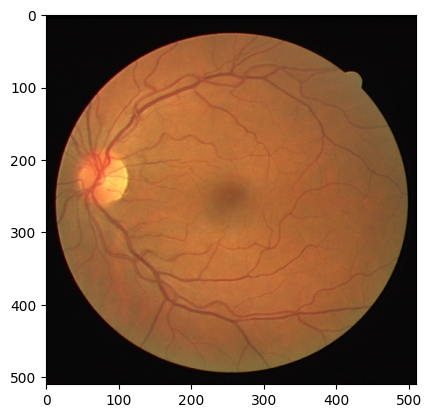

In [46]:
plt.imshow(img_test_no_border)

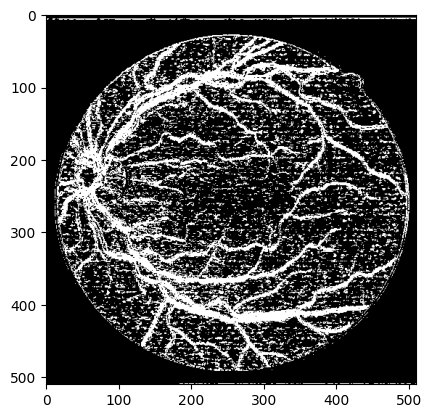

In [47]:
plt.imshow(pred_labels, cmap="grey")

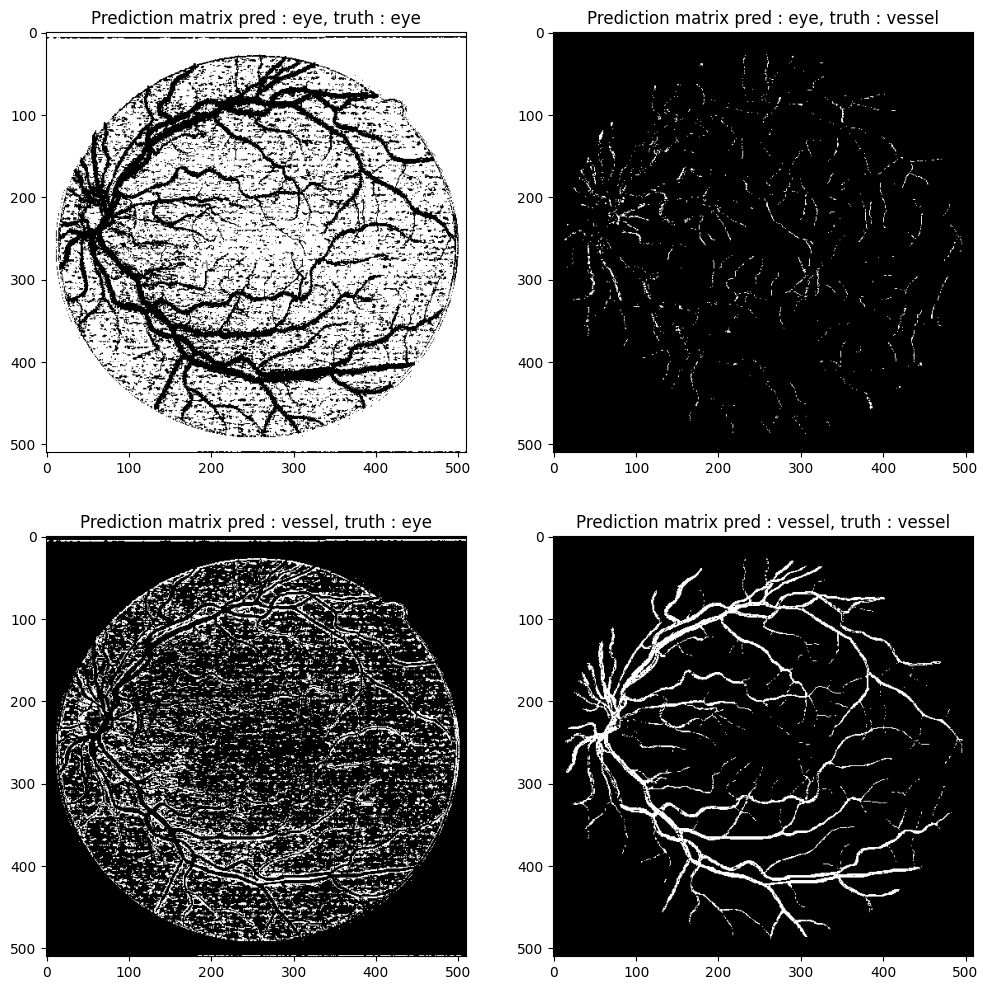

In [48]:
plt.figure(figsize=(12, 12))
for k,(i,j) in enumerate([(0,0),(0,1),(1,0),(1,1)]):
    plt.subplot(2, 2, k+1) 
    plt.imshow(np.array(pred_labels == i, dtype=np.float32)*np.array(y_test_no_border == j , dtype=np.float32), cmap="gray")
    plt.title(f"Prediction matrix pred : {'vessel' if i==1 else 'eye'}, truth : {'vessel' if j==1 else 'eye'}") 

